# Grover's Search Algorithm (3-qubit system)

In [56]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt

# Oracle

In [57]:
def oracle(circuit, target_state):
    # Apply X gates to qubits that are '0' in the target state
    for qubit in range(len(target_state)):
        if target_state[qubit] == '0':
            circuit.x(qubit)
    
    # Apply Hadamard, controlled-Z, and Hadamard to the last qubit
    circuit.h(len(target_state) - 1)
    circuit.mcx(list(range(len(target_state) - 1)), len(target_state) - 1)
    circuit.h(len(target_state) - 1)
    
    # Revert the X gates
    for qubit in range(len(target_state)):
        if target_state[qubit] == '0':
            circuit.x(qubit)

# Diffusion operator

In [58]:
def diffuser(circuit, nqubits):
   # Apply Hadamard gates to all qubits
    circuit.h(range(nqubits))
    
    # Apply X gates to all qubits
    circuit.x(range(nqubits))
    
    # Apply Hadamard, controlled-Z, and Hadamard to the last qubit
    circuit.h(nqubits - 1)
    circuit.mcx(list(range(nqubits - 1)), nqubits - 1)
    circuit.h(nqubits - 1)
    
    # Apply X gates to all qubits
    circuit.x(range(nqubits))
    
    # Apply Hadamard gates to all qubits
    circuit.h(range(nqubits))

# Circuit

Configuration

In [59]:
# Number of qubits
nqubits = 3

# Number of qubits
nqubits = 3


Circuit creation

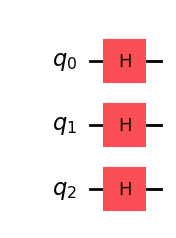

In [60]:
qc = QuantumCircuit(nqubits)


# Apply Hadamard gates to all qubits to create superposition
qc.h(range(nqubits))

qc.draw('mpl')

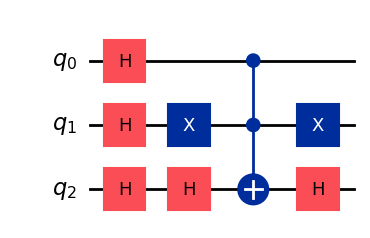

In [61]:
# Define the target state (binary string)
target_state = '101'

# Apply the oracle
oracle(qc, target_state)

qc.draw('mpl')

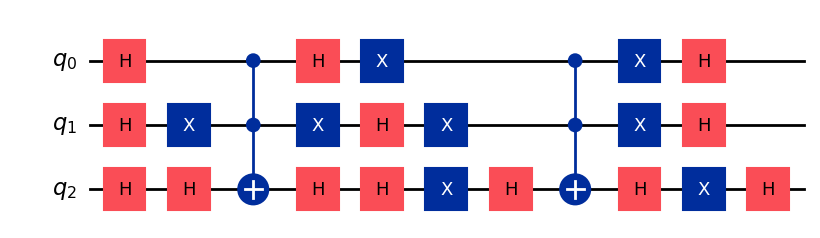

In [62]:
# Apply the diffuser
diffuser(qc, nqubits)

qc.draw('mpl')

Grover's iterate - 2 iterations total

In [63]:
oracle(qc, target_state)
diffuser(qc, nqubits)

Measurement

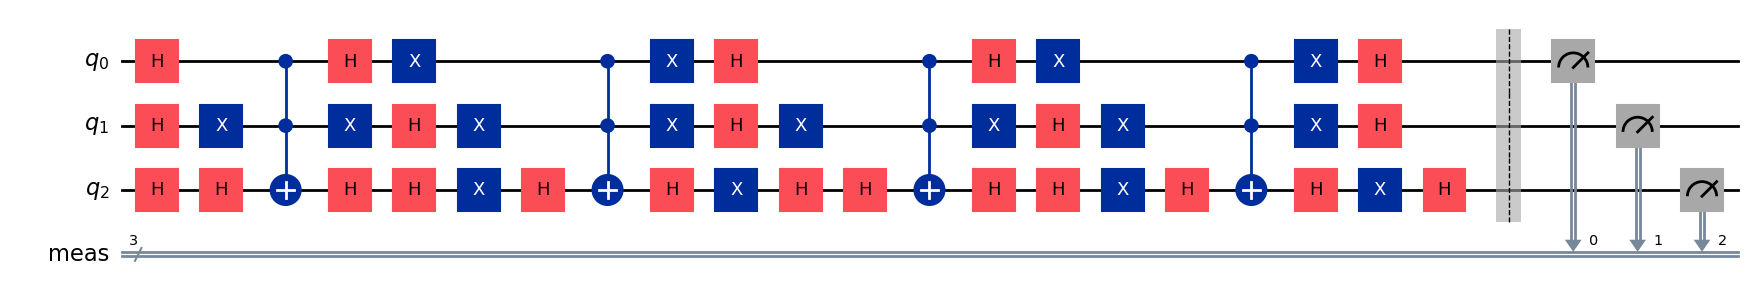

In [64]:
# Measure the qubits
qc.measure_all()

# Draw the circuit
qc.draw('mpl')

# Circult simulation with QASM

In [65]:
# Use the Aer's qasm_simulator
simulator = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator
circuit = transpile(qc, simulator)
job = simulator.run(circuit, shots=1000)


In [66]:
# Grab results from the job
result = job.result()
counts = result.get_counts()
print("\nTotal count for 0 and 1 are:",counts)


Total count for 0 and 1 are: {'100': 6, '110': 9, '001': 9, '011': 3, '111': 12, '000': 4, '010': 4, '101': 953}


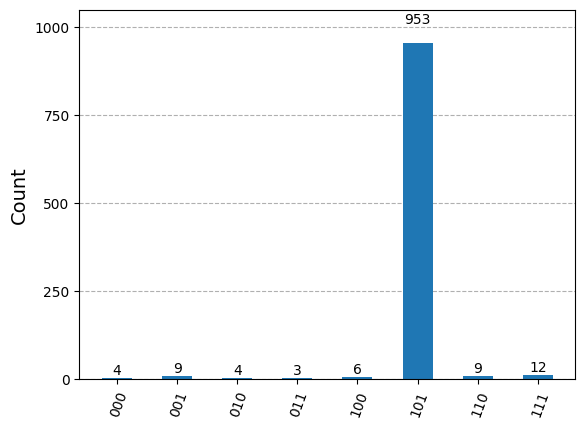

In [67]:
# Plot the histogram of the results
plot_histogram(counts)